In this notebook we implement and experiment with lasso for the sparsity.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from DeePyMoD_SBL.data.diffusion import library

np.random.seed(42)

In [2]:
# Making data
x_points = 100
t_points = 25
x_grid, t_grid = np.meshgrid(np.linspace(-10, 10, x_points), np.linspace(0, 1, t_points), indexing='ij')

In [3]:
# running library
time_deriv, theta = library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))

In [4]:
# running simple lsqt sq
np.linalg.lstsq(theta, time_deriv)[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([[-1.63868918e-15],
       [ 1.09490062e-15],
       [ 2.00000000e+00],
       [-1.99292069e-16],
       [-1.63466030e-15],
       [-2.44870886e-15],
       [-6.40287504e-16],
       [-3.00767500e-16],
       [-5.68286369e-16],
       [ 4.04989345e-15],
       [-2.32815344e-17],
       [ 4.00411254e-16]])

We should normalize the data to make life easier:

In [5]:
theta_normed = theta / np.linalg.norm(theta, axis=0, keepdims=True)
normalization = np.linalg.norm(theta, axis=0)

In [6]:
# running simple lsqt sq
np.linalg.lstsq(theta_normed, time_deriv)[0] / normalization[:, None]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([[-1.24219023e-16],
       [ 9.19051452e-16],
       [ 2.00000000e+00],
       [-7.41222024e-17],
       [-1.01472948e-15],
       [-2.95408622e-15],
       [ 8.98332473e-16],
       [-1.19224976e-16],
       [-3.50268091e-16],
       [ 4.82623380e-15],
       [ 4.12967009e-16],
       [ 4.65483978e-16]])

# Noise free exploration

In [7]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path

In [99]:
reg = Lasso(alpha=1e-5, fit_intercept=False)

In [100]:
reg.fit(theta_normed, time_deriv)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [103]:
reg.coef_ / normalization

array([-0.        , -0.        ,  1.99659939,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ])

Doesn't make a big difference but we should because its correct...

Now let's plot a lasso path:

In [104]:
reg = lasso_path(theta_normed, time_deriv, alphas=np.logspace(-7, -1, 100), fit_intercept=False)

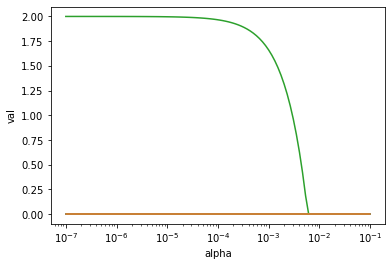

In [106]:
for coeff_idx in np.arange(reg[1].shape[1]):
    plt.semilogx(reg[0], reg[1][0, coeff_idx, :] / normalization[coeff_idx])
    
plt.xlabel('alpha')
plt.ylabel('val')
plt.show()

# Noise

Now let's add some noise...

In [107]:
noise_level = 0.1
noise = np.var(time_deriv) * noise_level
t = time_deriv + np.random.normal(scale= np.sqrt(noise), size=time_deriv.shape)

In [108]:
reg = lasso_path(theta_normed, t, alphas=np.logspace(-7, -1, 100), fit_intercept=False)

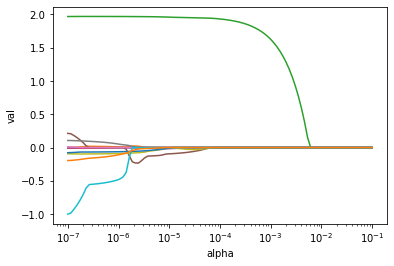

In [109]:
for coeff_idx in np.arange(reg[1].shape[1]):
    plt.semilogx(reg[0], reg[1][0, coeff_idx, :] / normalization[coeff_idx])
    
plt.xlabel('alpha')
plt.ylabel('val')
plt.show()

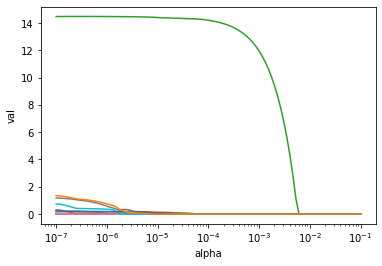

In [127]:
for coeff_idx in np.arange(reg[1].shape[1]):
    plt.plot(reg[0], np.abs(reg[1][0, coeff_idx, :]))
    
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('val')
plt.show()

# Range of noise

In [43]:
noise_levels = np.linspace(1e-3, 0.5, 100)

In [44]:
reg = Lasso(alpha=1e-5, fit_intercept=False)
result = []
threshold = 0.1

In [45]:
np.std(time_deriv)

0.2940645766126493

In [46]:
for noise in noise_levels:
    t = time_deriv + np.random.normal(scale= noise * np.std(time_deriv), size=time_deriv.shape)
    t_normed = t / np.linalg.norm(t)
    reg.fit(theta_normed, t_normed)
    thresholded_result = reg.coef_
    thresholded_result[np.abs(reg.coef_)< threshold]
    result.append(thresholded_result)
    
result = np.array(result)

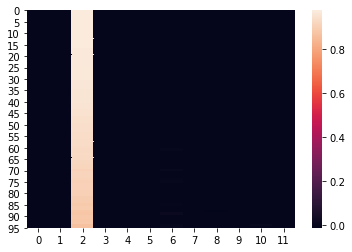

In [47]:
sns.heatmap(result)

In [48]:
result_contrasted = result
result_contrasted[result != 0.0] = 1.0

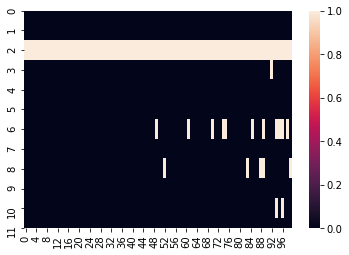

In [49]:
sns.heatmap(result_contrasted.T)

# Script for data

In [50]:
# Imports and settings
import numpy as np
from sklearn.linear_model import Lasso

np.random.seed(42)

In [51]:
# Loading data
data_dict = np.load('data.npy', allow_pickle=True).item()
time_deriv = data_dict['time_deriv']
theta = data_dict['theta']


In [74]:
# Initializing
noise_levels = np.linspace(1e-3, 1.0, 100)

repeats = 10

In [75]:
result = []
# Running Lasso
for noise in noise_levels:
    single_noise_result = []
    for repeat in np.arange(repeats):
        reg = Lasso(alpha=1e-5, fit_intercept=False)
        t = time_deriv + np.random.normal(scale=noise * np.std(time_deriv), size=time_deriv.shape)
        t_normed = t / np.linalg.norm(t)
        theta_normed = theta / np.linalg.norm(theta, axis=0, keepdims=True)
        reg.fit(theta_normed, t_normed)
        single_noise_result.append(reg.coef_)
    result.append(single_noise_result)

result = np.array(result)


In [79]:
# Thresholding and averaging
threshold = 0.0
thresholded_result = result
thresholded_result[np.abs(result) <= threshold] = 0.0
thresholded_result[np.abs(result) > threshold] = 1.0

correct_vec = np.zeros(12)
correct_vec[2] = 1.0

correct_result = np.all(thresholded_result == correct_vec[None, None, :], axis=2)


In [80]:
print(np.mean(correct_result, axis=1))

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9
 1.  1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.7 0.8 0.9
 0.8 0.8 0.7 0.7 0.7 0.9 0.8 0.6 1.  0.8 0.8 0.6 0.6 0.6 0.8 0.8 0.9 0.8
 0.6 0.8 0.6 0.5 0.8 0.6 0.5 0.9 0.5 0.7 0.5 0.6 0.5 0.7 0.8 0.3 0.9 0.6
 0.6 0.3 0.1 0.7 0.3 0.5 0.5 0.7 0.1 0.6 0.5 0.6 0.3 0.2 0.7 0.5 0.3 0.6
 0.5 0.5 0.6 0.2 0.5 0.5 0.3 0.3 0.4 0.6]


In [ ]:







thresholded_result[-1, 0, :]

data_dict = {'noise_levels': noise_levels, 'fit': result}
